# **Install Library**

In [1]:
!pip uninstall -y newspaper3k lxml
!pip install newspaper3k lxml_html_clean tqdm beautifulsoup4 requests pandas


Found existing installation: newspaper3k 0.2.8
Uninstalling newspaper3k-0.2.8:
  Successfully uninstalled newspaper3k-0.2.8
Found existing installation: lxml 6.0.2
Uninstalling lxml-6.0.2:
  Successfully uninstalled lxml-6.0.2
  Using cached newspaper3k-0.2.8-py3-none-any.whl.metadata (11 kB)
  Using cached lxml-6.0.2-cp312-cp312-manylinux_2_26_x86_64.manylinux_2_28_x86_64.whl.metadata (3.6 kB)
Using cached newspaper3k-0.2.8-py3-none-any.whl (211 kB)
Using cached lxml-6.0.2-cp312-cp312-manylinux_2_26_x86_64.manylinux_2_28_x86_64.whl (5.3 MB)


In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import re
import time

from bs4 import BeautifulSoup
from newspaper import Article
from tqdm import tqdm

# **Load Dataset**

In [4]:
sheet_url = "https://docs.google.com/spreadsheets/d/1kXpleC-xifxAv4CLKOH9L3aUga05p7vcn2g4fAVUkoE/export?format=csv"
df = pd.read_csv(sheet_url)
links = df.iloc[:, 2].dropna().tolist()

In [5]:
df

,No,PIC,Link,Label
0,1,Nala,https://money.kompas.com/read/2025/08/12/15391...,NaN
1,2,NaN,https://regional.kompas.com/read/2025/07/08/10...,NaN
2,3,NaN,https://video.kompas.com/watch/1858879/ombak-h...,NaN
3,4,NaN,https://money.kompas.com/read/2025/05/23/22053...,NaN
4,5,NaN,https://travel.kompas.com/read/2025/05/16/0707...,NaN
...,...,...,...,...
280,281,NaN,https://www.cnbcindonesia.com/news/20221223112...,NaN
281,282,NaN,https://www.cnbcindonesia.com/news/20221220120...,NaN
282,283,NaN,https://www.cnbcindonesia.com/news/20220924063...,NaN
283,284,NaN,https://www.cnbcindonesia.com/news/20210221221...,NaN


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      285 non-null    int64  
 1   PIC     3 non-null      object 
 2   Link    285 non-null    object 
 3   Label   0 non-null      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 9.0+ KB


# **Scraping News**

In [6]:
def scrape_berita(url):
    data = {
        "Judul Berita": None,
        "Text Berita": None,
        "Tanggal Berita": None,
        "Tag": None,
        "Link": url
    }
    try:
        # Coba dengan newspaper3k dulu
        article = Article(url, language="id")
        article.download()
        article.parse()

        data["Judul Berita"] = article.title
        data["Text Berita"] = article.text
        data["Tanggal Berita"] = article.publish_date
        data["Tag"] = ", ".join(article.meta_keywords) if article.meta_keywords else None

    except Exception as e:
        try:
            response = requests.get(url, timeout=10, headers={"User-Agent": "Mozilla/5.0"})
            soup = BeautifulSoup(response.text, "html.parser")

            # Judul
            title = soup.find("title")
            data["Judul Berita"] = title.get_text().strip() if title else None

            # Isi teks
            paragraphs = [p.get_text() for p in soup.find_all("p")]
            data["Text Berita"] = " ".join(paragraphs)

            # Tanggal publikasi
            date_meta = soup.find("meta", {"property": "article:published_time"})
            if not date_meta:
                date_meta = soup.find("meta", {"name": "date"})
            data["Tanggal Berita"] = date_meta["content"] if date_meta and "content" in date_meta.attrs else None

            # Tag
            tag_meta = soup.find("meta", {"property": "article:tag"})
            if not tag_meta:
                tag_meta = soup.find("meta", {"name": "keywords"})
            data["Tag"] = tag_meta["content"] if tag_meta and "content" in tag_meta.attrs else None

        except Exception as e2:
            print(f"❌ Gagal scrape {url}: {e2}")

    return data

In [7]:
results = []
for link in tqdm(links, desc="Scraping berita..."):
    hasil = scrape_berita(link)
    results.append(hasil)
    time.sleep(1)

Scraping berita...: 100%|██████████| 285/285 [11:52<00:00,  2.50s/it]


In [33]:
output_df = pd.DataFrame(results)
output_df.to_csv("berita_raw.csv", index=False, encoding="utf-8-sig")
print("Scraping Berita Selesai dan tersimpan di 'berita_raw.csv'")

Scraping Berita Selesai dan tersimpan di 'berita_raw.csv'


# **Data Preprocessing**

In [34]:
output_df['Tanggal Berita']

,Tanggal Berita
0,2025-08-12 00:00:00
1,2025-07-08 00:00:00
2,2025-07-03 02:09:12+00:00
3,2025-05-23 00:00:00
4,2025-05-16 00:00:00
...,...
280,2022-12-23 12:32:38
281,2022-12-20 13:48:24
282,2022-09-24 08:00:00
283,2021-02-22 06:00:00


In [36]:
output_df['Tanggal Berita'] = pd.to_datetime(
    output_df['Tanggal Berita'],
    errors='coerce',
    utc=True,  # jika ada timezone
    infer_datetime_format=True
)

print("Jumlah tanggal valid:", output_df['Tanggal Berita'].notna().sum())
print("Jumlah tanggal kosong:", output_df['Tanggal Berita'].isna().sum())
print(output_df['Tanggal Berita'].head(10))

Jumlah tanggal valid: 285
Jumlah tanggal kosong: 0
0   2025-08-12 00:00:00+00:00
1   2025-07-08 00:00:00+00:00
2   2025-07-03 02:09:12+00:00
3   2025-05-23 00:00:00+00:00
4   2025-05-16 00:00:00+00:00
5   2025-04-10 00:00:00+00:00
6   2025-04-05 00:00:00+00:00
7   2025-04-02 00:00:00+00:00
8   2025-04-02 00:00:00+00:00
9   2025-03-26 00:00:00+00:00
Name: Tanggal Berita, dtype: datetime64[ns, UTC]


/tmp/ipython-input-3666873602.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  output_df['Tanggal Berita'] = pd.to_datetime(


In [38]:
# Split kolom Tag
output_df['Tag'] = output_df['Tag'].astype(str).str.lower()
output_df['Tag'] = output_df['Tag'].apply(lambda x: [t.strip() for t in x.split(',') if t.strip() != ''])
tags_exploded = output_df.explode('Tag')

# **Visualization**

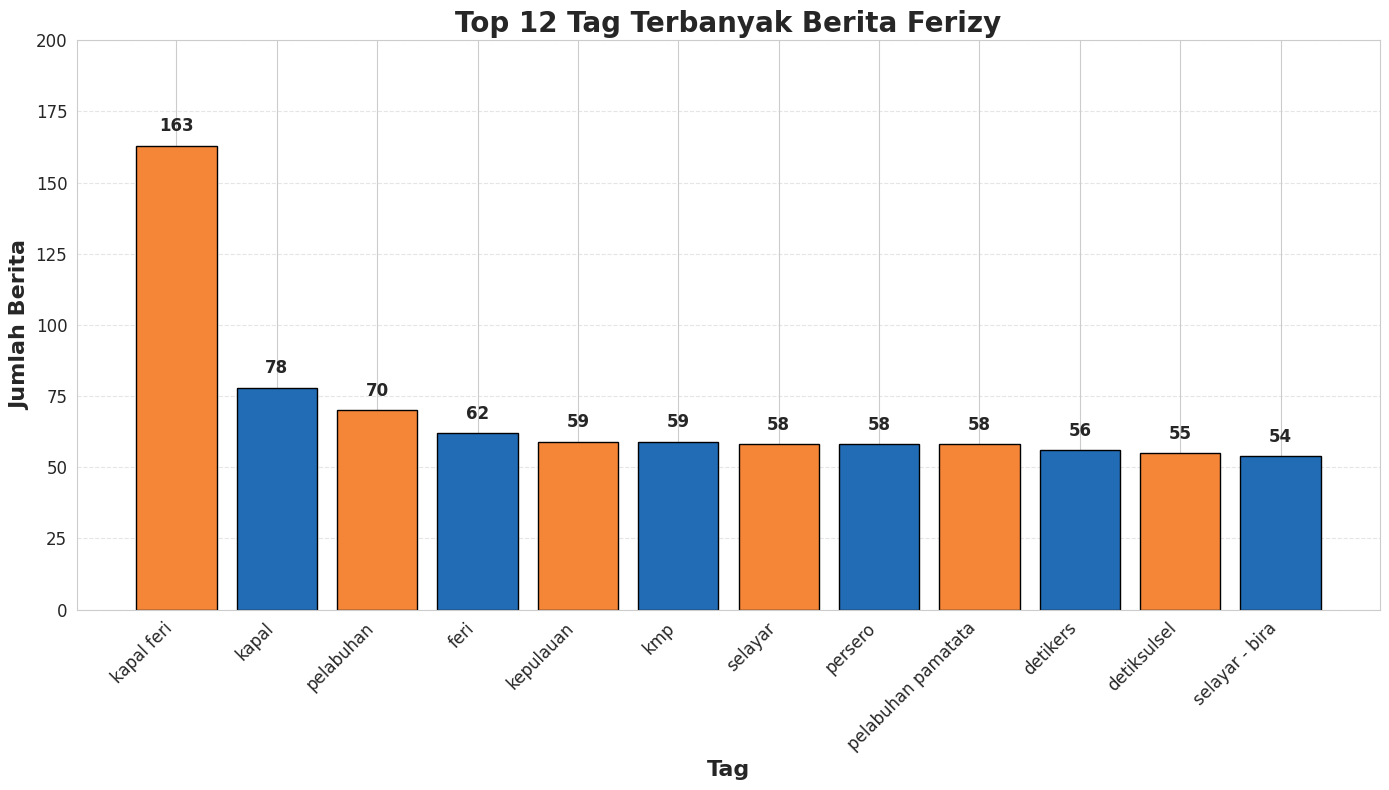

In [64]:
import matplotlib.pyplot as plt

# Top 20 Tag
top_tags = tags_exploded['Tag'].value_counts().head(12)

colors = ['#f58638' if i % 2 == 0 else '#216cb5' for i in range(len(top_tags))]

plt.figure(figsize=(14,8))
bars = plt.bar(top_tags.index, top_tags.values, color=colors, edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(height),  # geser 5 unit ke atas
             ha='center', fontsize=12, weight='bold')

plt.title('Top 12 Tag Terbanyak Berita Ferizy', fontsize=20, weight='bold')
plt.xlabel('Tag', fontsize=16, weight='bold')
plt.ylabel('Jumlah Berita', fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 200)  # maksimum 200
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipython-input-341733748.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  output_df['Periode_Quartal'] = output_df['Tanggal Berita'].dt.to_period('Q')


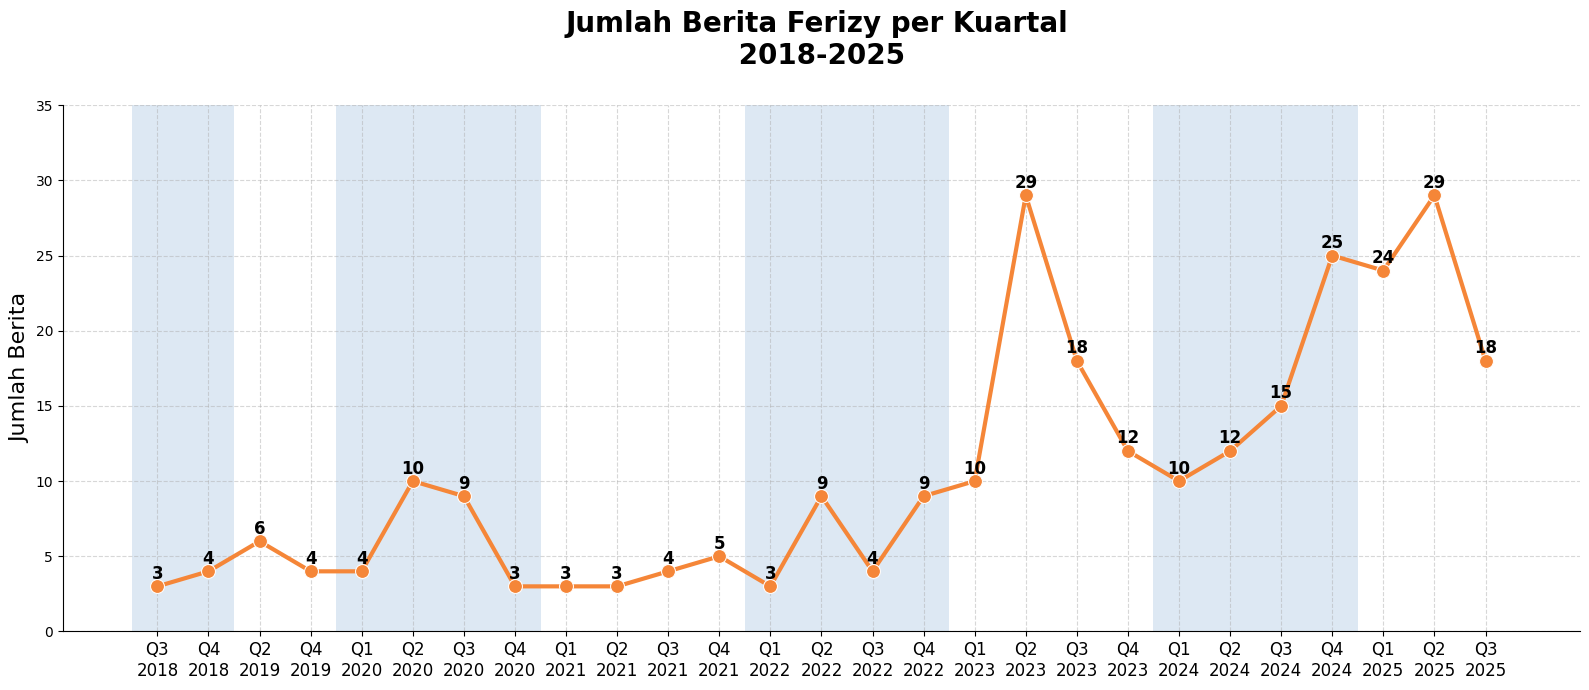

In [54]:
output_df['Periode_Quartal'] = output_df['Tanggal Berita'].dt.to_period('Q')
quarterly_counts = output_df.groupby('Periode_Quartal').size().reset_index(name='Jumlah Berita')

quarterly_counts['Q'] = 'Q' + quarterly_counts['Periode_Quartal'].dt.quarter.astype(str)
quarterly_counts['Year'] = quarterly_counts['Periode_Quartal'].dt.year.astype(str)

x = np.arange(len(quarterly_counts))
y = quarterly_counts['Jumlah Berita']

plt.figure(figsize=(16,7))
ax = plt.gca()

years = quarterly_counts['Year'].unique()
colors = ['#8fb5d9', 'white']  # selang-seling
for i, year in enumerate(years):
    idx = quarterly_counts[quarterly_counts['Year']==year].index
    if len(idx) > 0:
        ax.axvspan(idx[0]-0.5, idx[-1]+0.5, facecolor=colors[i % 2], alpha=0.3, zorder=0)

sns.lineplot(x=x, y=y, marker='o', markersize=10, linewidth=3, color='#f58638', zorder=5)

for xi, yi in zip(x, y):
    plt.text(xi, yi+0.5, str(yi), ha='center', fontsize=12, weight='bold', zorder=6)

ax.set_xticks(x)
ax.set_xticklabels([f"{q}\n{year}" for q, year in zip(quarterly_counts['Q'], quarterly_counts['Year'])], fontsize=12)

plt.ylim(0, 35)

plt.title('Jumlah Berita Ferizy per Kuartal \n 2018-2025 \n', fontsize=20, weight='bold')
plt.ylabel('Jumlah Berita', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5, zorder=1)
sns.despine()
plt.tight_layout()
plt.show()


/tmp/ipython-input-4019216461.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  output_df['Periode_Quartal'] = output_df['Tanggal Berita'].dt.to_period('Q')


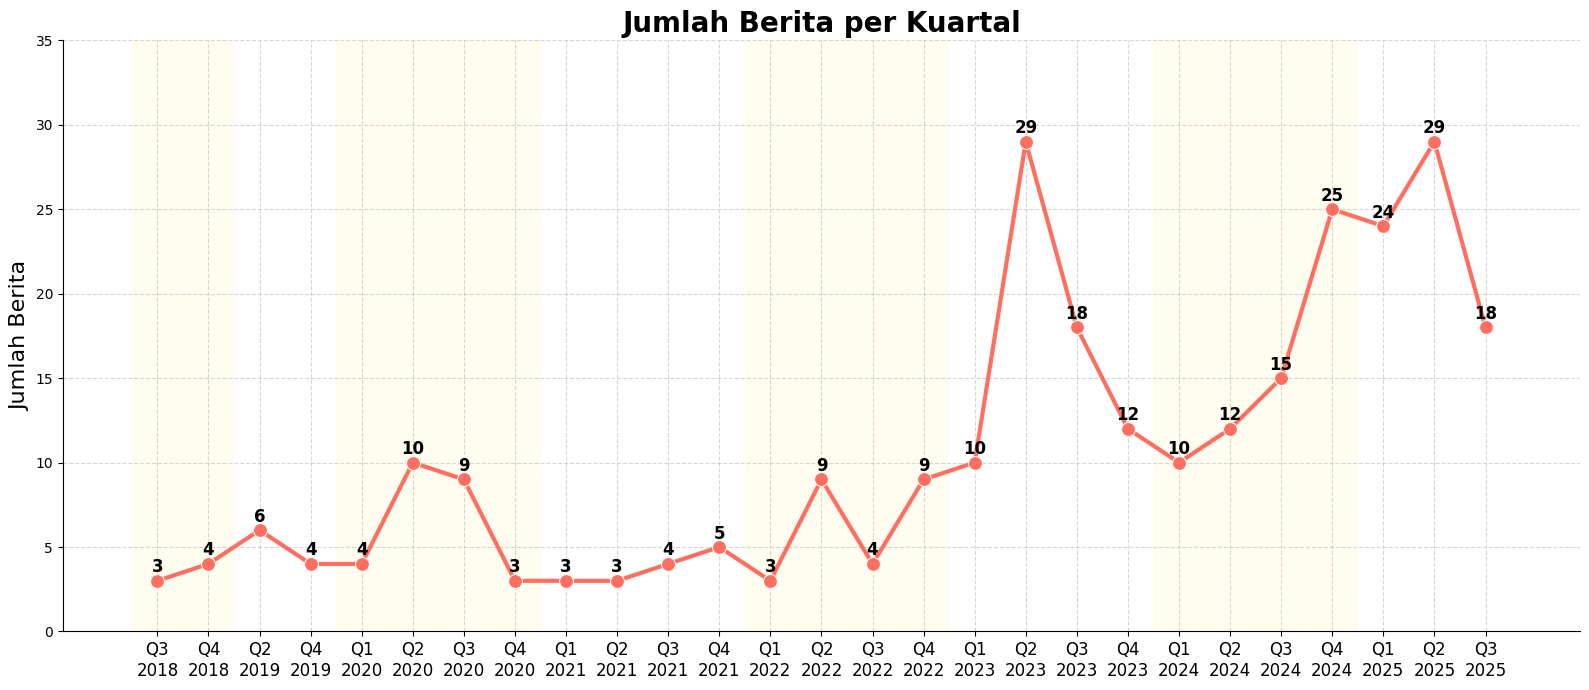

In [49]:
# Buat kolom periode per kuartal
output_df['Periode_Quartal'] = output_df['Tanggal Berita'].dt.to_period('Q')
quarterly_counts = output_df.groupby('Periode_Quartal').size().reset_index(name='Jumlah Berita')

quarterly_counts['Q'] = 'Q' + quarterly_counts['Periode_Quartal'].dt.quarter.astype(str)
quarterly_counts['Year'] = quarterly_counts['Periode_Quartal'].dt.year.astype(str)

x = np.arange(len(quarterly_counts))
y = quarterly_counts['Jumlah Berita']

plt.figure(figsize=(16,7))
ax = plt.gca()

years = quarterly_counts['Year'].unique()
colors = ['#FFFACD', 'white']
for i, year in enumerate(years):
    idx = quarterly_counts[quarterly_counts['Year']==year].index
    if len(idx) > 0:
        ax.axvspan(idx[0]-0.5, idx[-1]+0.5, facecolor=colors[i % 2], alpha=0.3, zorder=0)

sns.lineplot(x=x, y=y, marker='o', markersize=10, linewidth=3, color='#FF6F61', zorder=5)

for xi, yi in zip(x, y):
    plt.text(xi, yi+0.5, str(yi), ha='center', fontsize=12, weight='bold', zorder=6)

ax.set_xticks(x)
ax.set_xticklabels([f"{q}\n{year}" for q, year in zip(quarterly_counts['Q'], quarterly_counts['Year'])], fontsize=12)

plt.ylim(0, 35)
plt.title('Jumlah Berita Ferizy per Kuartal', fontsize=20, weight='bold')
plt.ylabel('Jumlah Berita', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5, zorder=1)
sns.despine()
plt.tight_layout()
plt.show()


In [66]:
output_df.head()

,Judul Berita,Text Berita,Tanggal Berita,Tag,Link,Periode,Periode_Quartal
0,ASDP dan Operator Ferry Swasta Perkuat Data Ma...,"JAKARTA, KOMPAS.com — Manifest penumpang dan k...",2025-08-12 00:00:00+00:00,"[asdp, kapal ferry, manifest penumpang, operat...",https://money.kompas.com/read/2025/08/12/15391...,2025-08,2025Q3
1,"Listrik di Pulau Enggano Sudah 24 Jam, Kapal F...","BENGKULU, KOMPAS.com - Kepala Desa Kaana, Alam...",2025-07-08 00:00:00+00:00,"[pulau enggano, bio solar, pelabuhan pulau baa...",https://regional.kompas.com/read/2025/07/08/10...,2025-07,2025Q3
2,"Ombak Hingga 2,5 Meter Hambat Pencarian KMP Tu...","KMP Tunu Pratama Jaya tenggelam di Selat Bali,...",2025-07-03 02:09:12+00:00,"[berita terkini, berita hari ini, berita haria...",https://video.kompas.com/watch/1858879/ombak-h...,2025-07,2025Q3
3,Rute Ferry Batam–Johor Direncanakan Aktif Tahu...,KOMPAS.com – PT Angkutan Sungai Danau dan Peny...,2025-05-23 00:00:00+00:00,"[kapal ferry, batam johor bahru ferry schedule...",https://money.kompas.com/read/2025/05/23/22053...,2025-05,2025Q2
4,"Menyeberangi Danau Toba, Perjalanan Naik Kapal...",KOMPAS.com - Kala melihat kapal berwarna hijau...,2025-05-16 00:00:00+00:00,"[kapal dari ajibata ke tomok, kapal ferry pela...",https://travel.kompas.com/read/2025/05/16/0707...,2025-05,2025Q2


In [67]:
output_df = pd.DataFrame(results)
output_df.to_csv("berita_raw_prep.csv", index=False, encoding="utf-8-sig")
print("Hasil Scraping telah terproses di 'berita_raw_prep.csv'")

Hasil Scraping telah terproses di 'berita_raw_prep.csv'
